In [2]:
import numpy as np
import pandas as pd
import glob
import os
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

In [3]:
##Extracting the first column of every excel which contains the fslr
# Specify the directory containing the Excel files
directory = "brca_correlaties/09-18_12-10_all_10k_biomart_final"

# Get a list of all Excel files in the directory
excel_files = glob.glob(os.path.join(directory, '*.csv'))
# print(excel_files)
# Initialize an empty dictionary to hold data from each file
data_dict = {}

# Loop through each file and extract the second column
for file in excel_files:
    # Read the Excel file
    df = pd.read_csv(file)

    
    # Ensure the file has at least 2 columns
    if df.shape[1] < 2:
        print(f"File {file} does not have a second column.")
        continue
    
    # Extract the second column (index 1)
    second_column = df.iloc[:, 1]
    # Check if the second column contains only zeros
    if second_column.eq(0).all():
        print(f"File {file} has only zeros in the second column. Skipping this file.")
        continue
    
    # Use the file name (without extension) as the column name
    file_name = os.path.basename(file).replace('.csv', '')
    data_dict[file_name] = second_column

# Create a DataFrame from the dictionary 
combined_df = pd.DataFrame(data_dict) 

# Set the index to the peak locations if available
# Ensure that the index is the same for all files
if not combined_df.empty:
    combined_df.index.name = 'Peak'

# Save the combined DataFrame to a new Excel file
combined_df.to_csv('TSSClassification/brca_correlaties/cfDNA_matrix.csv')

print("Combined matrix saved to cfDNA_matrix.csv")
print(combined_df)

Combined matrix saved to cfDNA_matrix.csv
Empty DataFrame
Columns: []
Index: []


In [18]:
coad_atac_matrix = pd.read_csv('/mnt/c/Users/donna/Downloads/Thesis/TSSclassification/brca_correlaties/TCGA_coad_full_single.csv', index_col=None)  # Assuming rows are peaks and columns are samples
brca_atac_matrix = pd.read_csv('/mnt/c/Users/donna/Downloads/Thesis/TSSclassification/brca_correlaties/atac_single_brca_sample.csv', index_col=None)  # Assuming rows are peaks and columns are samples

# Ensure atac_matrix has a "peak" column
brca_atac_matrix.insert(0, 'Peak', range(len(brca_atac_matrix)))  # Add peak numbers
# Ensure atac_matrix has a "peak" column
coad_atac_matrix.insert(0, 'Peak', range(len(coad_atac_matrix)))  # Add peak numbers

# Aligning both matrices on the 'peak' column
brca_atac_matrix = brca_atac_matrix.set_index('Peak')  
coad_atac_matrix = coad_atac_matrix.set_index('Peak')  
print(brca_atac_matrix)
#Only selecting firts column (1 sample)
brca_atac_matrix = brca_atac_matrix.iloc[:,[0]]
coad_atac_matrix = coad_atac_matrix.iloc[:,[0]]
print(brca_atac_matrix)
cf_coad_matrix = pd.read_csv('/mnt/c/Users/donna/Downloads/Thesis/TSSclassification/results/cf_single_coad_full/ff_single_coad_bam.csv', index_col=0)
cf_coad_matrix = cf_coad_matrix["cov_x"].to_frame()
cf_brca_matrix = pd.read_csv('/mnt/c/Users/donna/Downloads/Thesis/TSSclassification/results/cf_single_brca_full/ff_single_brca_bam.csv', index_col=0)
cf_brca_matrix = cf_brca_matrix["cov_x"].to_frame()




        TCGA-AR-A0U0-01A
Peak                    
0              -0.286106
1              -1.169270
2              -0.988460
3               1.412817
4               1.508600
...                  ...
562704         -1.174376
562705         -1.098967
562706         -0.834110
562707         -0.988460
562708          0.288671

[562709 rows x 1 columns]
        TCGA-AR-A0U0-01A
Peak                    
0              -0.286106
1              -1.169270
2              -0.988460
3               1.412817
4               1.508600
...                  ...
562704         -1.174376
562705         -1.098967
562706         -0.834110
562707         -0.988460
562708          0.288671

[562709 rows x 1 columns]


In [8]:
print(len(brca_atac_matrix[:550203]))
print(len(cf_brca_matrix))
brca_atac_matrix = brca_atac_matrix[:550203]

550203
550203


In [14]:
##Removing outlier
Q1 = cf_brca_matrix.quantile(0.25)  # First quartile (25%)
Q3 = cf_brca_matrix.quantile(0.75)  # Third quartile (75%)
IQR = Q3 - Q1  # Interquartile range

# Define lower and upper bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Keep only values inside the bounds
cf_brca_matrix_filtered = cf_brca_matrix[(cf_brca_matrix >= lower_bound) & (cf_brca_matrix <= upper_bound)]


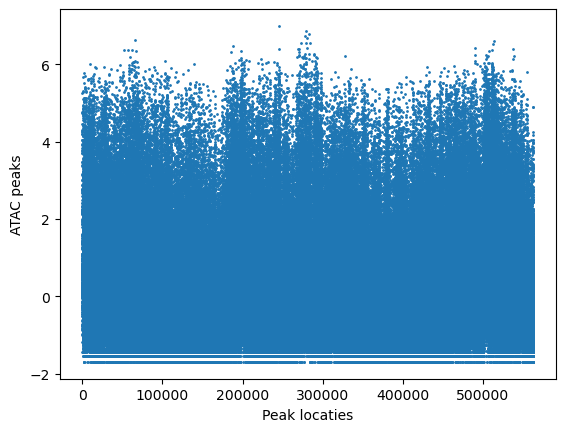

In [25]:
plt.scatter(brca_atac_matrix.index, brca_atac_matrix.iloc[:,0], s=1)
plt.xlabel("Peak locaties")
plt.ylabel("ATAC peaks")
plt.show()

In [66]:
## Funtcion to check for constan values
def is_constant(series):
    """Check if a pandas Series contains constant values."""
    return series.nunique() == 1

In [67]:
def calculate_correlation_matrix(atac_matrix, cf_matrix):
    """
    Calculates the Pearson correlation between each pair of columns
    from two matrices (matrix1 and matrix2) based on their row values.

    Parameters:
    - matrix1: pandas DataFrame, where columns are samples, and rows are features (e.g., peaks)
    - matrix2: pandas DataFrame, where columns are samples, and rows are features (e.g., peaks)

    Returns:
    - correlation_matrix: pandas DataFrame containing Pearson correlations between samples of matrix1 and matrix2
    """
    # Initialize the correlation matrix with zeros
    correlation_matrix = pd.DataFrame(
        np.nan,
        index=atac_matrix.columns,
        columns=cf_matrix.columns
    )

    # Loop through each pair of samples from matrix1 and matrix2
    for col1 in atac_matrix.columns:
        for col2 in cf_matrix.columns:
            # Extract data for the current pair of samples
            data1 = atac_matrix[col1].astype(float)
            data2 = cf_matrix[col2].astype(float)
            
            # **Ensure indices match**
            data1, data2 = data1.align(data2, join='inner')  
            ##Constant values check
            # Skip correlation calculation if one of the columns has NaN, or is constant
            if data1.isna().all():
                print(f"Skipping {col1} due to all NaN values in matrix 1.")
                continue

            if data2.isna().all():
                print(f"Skipping {col2} due to all NaN values in matrix 2.")
                continue

            if is_constant(data1):
                print(f"Skipping {col1} in matrix 1 due to constant values.")
                continue

            if is_constant(data2):
                print(f"Skipping {col2} in matrix 2 due to constant values.")
                continue

          
            # Calculate the Pearson correlation
            corr, _ = pearsonr(data1, data2)
            
            # Store the correlation value in the matrix
            correlation_matrix.loc[col1, col2] = corr

    return correlation_matrix


# Print the correlation matrix
corr_atac_brca_cf_coad = calculate_correlation_matrix(brca_atac_matrix, cf_coad_matrix)
corr_atac_coad_cf_coad = calculate_correlation_matrix(coad_atac_matrix, cf_coad_matrix)
corr_atac_brca_cf_brca = calculate_correlation_matrix(brca_atac_matrix, cf_brca_matrix)
corr_atac_coad_cf_brca = calculate_correlation_matrix(coad_atac_matrix, cf_brca_matrix)


In [68]:
# Save the correlation matrix to a CSV file
corr_atac_coad_cf_coad.to_csv('corr_atac_coad_cf_coad.csv')
corr_atac_brca_cf_brca.to_csv('corr_atac_brca_cf_brca.csv')
corr_atac_brca_cf_coad.to_csv('corr_atac_brca_cf_coad.csv')
corr_atac_coad_cf_brca.to_csv('corr_atac_coad_cf_brca.csv')

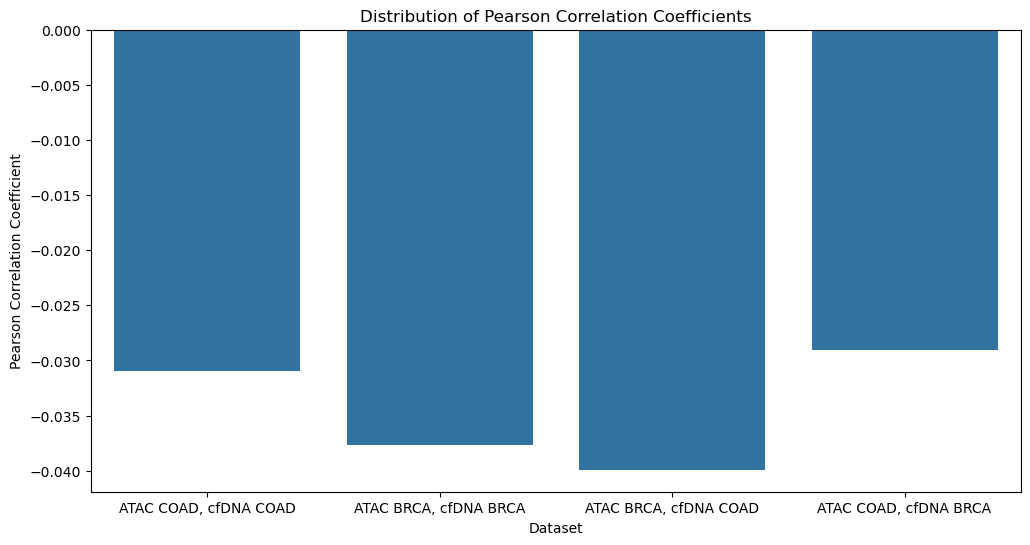

In [69]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt



# Convert the correlation matrices to long format
corr_atac_coad_cf_coad_long = corr_atac_coad_cf_coad.melt(var_name='cfDNA Sample', value_name='Correlation')
corr_atac_coad_cf_coad_long['ATAC Sample'] = corr_atac_coad_cf_coad_long.index

corr_atac_brca_cf_brca_long = corr_atac_brca_cf_brca.melt(var_name='cfDNA Sample', value_name='Correlation')
corr_atac_brca_cf_brca_long['ATAC Sample'] = corr_atac_brca_cf_brca_long.index

corr_atac_brca_cf_coad_long = corr_atac_brca_cf_coad.melt(var_name='cfDNA Sample', value_name='Correlation')
corr_atac_brca_cf_coad_long['ATAC Sample'] = corr_atac_brca_cf_coad.index

corr_atac_coad_cf_brca_long = corr_atac_coad_cf_brca.melt(var_name='cfDNA Sample', value_name='Correlation')
corr_atac_coad_cf_brca_long['ATAC Sample'] =corr_atac_coad_cf_brca_long.index

# Add a column to indicate which dataset the correlations come from
corr_atac_coad_cf_coad_long['Dataset'] = 'ATAC COAD, cfDNA COAD'
corr_atac_brca_cf_brca_long['Dataset'] = 'ATAC BRCA, cfDNA BRCA'
corr_atac_brca_cf_coad_long['Dataset'] = 'ATAC BRCA, cfDNA COAD'
corr_atac_coad_cf_brca_long['Dataset'] = 'ATAC COAD, cfDNA BRCA'

# Combine the long-format dataframes
combined_corr_long = pd.concat([corr_atac_coad_cf_coad_long, corr_atac_brca_cf_brca_long, corr_atac_brca_cf_coad_long, corr_atac_coad_cf_brca_long])

# Create the box plot
plt.figure(figsize=(12, 6))
sns.barplot(x='Dataset', y='Correlation', data=combined_corr_long)
plt.title('Distribution of Pearson Correlation Coefficients')
plt.xlabel('Dataset')
plt.ylabel('Pearson Correlation Coefficient')
plt.show()
